# Import Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

In [2]:
train = pd.read_csv('../Dataset/train_small.csv')
test = pd.read_csv('../Dataset/test_small.csv')

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (307511, 280)
Test shape:  (48744, 279)


# Model: LGBM Classfier

In [3]:
# Extract the labels
labels = train['TARGET']
features = train.drop(columns=['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.25, random_state=17)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (230633, 278)
Test shape:  (76878, 278)


,CREDIT_TERM,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,client_installments_payments_AMT_PAYMENT_min_sum,AMT_ANNUITY,client_pos_cash_CNT_INSTALMENT_FUTURE_mean_max,bureau_DAYS_CREDIT_max,...,client_installments_payments_NUM_INSTALMENT_VERSION_sum_sum,previous_NAME_GOODS_CATEGORY_ConsumerElectronics_mean,client_credit_card_AMT_CREDIT_LIMIT_ACTUAL_min_sum,client_credit_card_SK_DPD_mean_min,bureau_CREDIT_ACTIVE_Sold_count_norm,client_bureau_balance_MONTHS_BALANCE_count_max,previous_NAME_CLIENT_TYPE_New_mean,previous_CODE_REJECT_REASON_LIMIT_mean,client_credit_card_AMT_DRAWINGS_ATM_CURRENT_sum_sum,previous_WEEKDAY_APPR_PROCESS_START_TUESDAY_mean
89672,0.102457,0.719170,0.541840,0.472253,-8093.0,16834,65330.550,16137.0,6.818182,-126.0,...,110.0,0.0,NaN,NaN,0.0,36.0,1.0,0.0,NaN,0.0
238736,0.061293,NaN,0.615644,0.185202,-5438.0,15884,31119.480,9252.0,36.000000,-82.0,...,91.0,0.0,NaN,NaN,0.0,9.0,0.5,0.0,NaN,0.0
278307,0.051056,0.391970,0.323001,0.461482,-1551.0,10730,40367.703,41355.0,3.000000,-376.0,...,36.0,0.0,NaN,NaN,0.0,80.0,1.0,0.0,NaN,0.0
181026,0.050000,NaN,0.705380,0.636376,-358.0,15654,162577.530,19125.0,8.000000,-131.0,...,169.0,0.0,NaN,NaN,0.0,NaN,0.5,0.0,NaN,0.0
66008,0.048328,0.656476,0.477630,NaN,-1456.0,19008,68668.160,28530.0,20.000000,NaN,...,81.0,0.5,405000.0,0.0,NaN,NaN,1.0,0.0,668250.0,0.0


## Imbalanced Dataset

In [4]:
def custom_loss_function(y_true, y_pred):
    cost = 0
    ratio = 15
    cost = (((y_true == 0) & (y_pred == 1))*1).sum() + \
        (((y_true == 1) & (y_pred == 0))*ratio).sum()
    return cost

In [5]:
def custom_function_amt_credit(y_true, y_pred, x_features):
    credit = x_features['AMT_CREDIT']
    cost = 0
    ratio = 15
    cost = (((y_true == 0) & (y_pred == 1))*1*credit).sum() + \
        (((y_true == 1) & (y_pred == 0))*ratio*credit).sum()
    return cost/x_features['AMT_CREDIT'].sum()

In [6]:
from sklearn.metrics import make_scorer

scorer = make_scorer(custom_loss_function, greater_is_better=False)

In [7]:
model = lgb.LGBMClassifier(random_state=17, verbose=-1, force_col_wise=True)

# lgb.Dataset
train_set = lgb.Dataset(train_features, label=train_labels)
test_set = lgb.Dataset(test_features, label=test_labels)

In [8]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

gridParams = {'num_leaves': sp_randint(6, 50),
              'min_child_samples': sp_randint(100, 500),
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8),
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

grid = RandomizedSearchCV(
    model, param_distributions=gridParams, verbose=1, cv=N_FOLDS, n_jobs=-1, n_iter=5, scoring=scorer, random_state=17)

grid.fit(train_features, train_labels)
print('Best score reached: {} with params:\n {} '.format(
    grid.best_score_, grid.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score reached: -53277.6 with params:
 {'colsample_bytree': 0.7422504150750135, 'min_child_samples': 266, 'min_child_weight': 0.001, 'num_leaves': 43, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.5022832470118295} 


In [9]:
hyperparameters = {key: grid.best_params_.get(
    key, model.get_params()[key]) for key in model.get_params()}

In [10]:
# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=10000, nfold=N_FOLDS, metrics='auc',
                    early_stopping_rounds=100, verbose_eval=False, seed=17)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(
    best, best_std))
print('The ideal number of iterations was {}.'.format(
    len(cv_results['auc-mean'])))

/Users/ruspa/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1075: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


The maximium ROC AUC in cross validation was 0.77969 with std of 0.00272.
The ideal number of iterations was 168.


In [11]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])
model.set_params(**hyperparameters)

# Train and make predicions with model
model.fit(train_features, train_labels)

preds_proba = model.predict_proba(test_features)[:, 1]
preds = model.predict(test_features)

imbalanced_auc = roc_auc_score(test_labels, preds_proba)

print('The imbalanced model scores {:.5f} ROC AUC on the test set.'.format(
    imbalanced_auc))

The imbalanced model scores 0.78079 ROC AUC on the test set.


### Visualisation

In [12]:
def plot_2d_space(X, y, label='Classes'):

    plt.figure(figsize=(8, 6))
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y == l, 0],
            X[y == l, 1],
            c=c, label=l, marker=m
        )

    plt.title(label)
    plt.legend()
    plt.show()

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

imputer = SimpleImputer(strategy='median')

X_imputed = imputer.fit_transform(train_features)

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_imputed)

print('Features shape: ', train_features.shape)
print('Labels shape: ', train_labels.shape)
print(train_labels.value_counts())

Features shape:  (230633, 278)
Labels shape:  (230633,)
0    212064
1     18569
Name: TARGET, dtype: int64


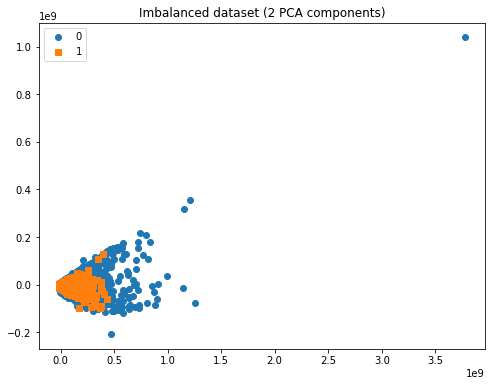

In [14]:
plot_2d_space(X_pca, train_labels, 'Imbalanced dataset (2 PCA components)')

### Metrics

In [15]:
from sklearn.metrics import classification_report, accuracy_score

cl_report_imbalanced = classification_report(
    test_labels, preds, output_dict=True)

cus_metric_imbalanced = custom_loss_function(test_labels, preds)
cus_metric_amt_ann_imbalanced = custom_function_amt_credit(
    test_labels, preds, test_features)

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70622
           1       0.55      0.06      0.10      6256

    accuracy                           0.92     76878
   macro avg       0.74      0.53      0.53     76878
weighted avg       0.89      0.92      0.89     76878



## Random undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(train_features, train_labels)

print('Features shape: ', X_rus.shape)
print('Labels shape: ', y_rus.shape)
print(y_rus.value_counts())

Features shape:  (37138, 278)
Labels shape:  (37138,)
0    18569
1    18569
Name: TARGET, dtype: int64


### Visualisation

In [17]:
X_rus_imputed = imputer.fit_transform(X_rus)

X_rus_pca = pca.fit_transform(X_rus_imputed)

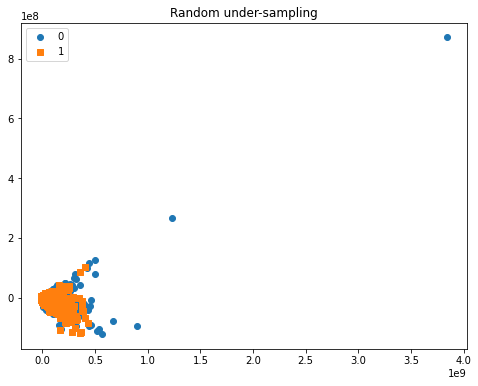

In [18]:
plot_2d_space(X_rus_pca, y_rus, 'Random under-sampling')

### Metrics

In [19]:
# Train and make predicions with model
model.fit(X_rus, y_rus)

preds_proba = model.predict_proba(test_features)[:, 1]
preds = model.predict(test_features)

rus_auc = roc_auc_score(test_labels, preds_proba)

print('The random undersampling model scores {:.5f} ROC AUC on the test set.'.format(
    rus_auc))

The random undersampling model scores 0.77735 ROC AUC on the test set.


In [20]:
cl_report_rus = classification_report(
    test_labels, preds, output_dict=True)

cus_metric_rus = custom_loss_function(test_labels, preds)
cus_metric_amt_ann_rus = custom_function_amt_credit(
    test_labels, preds, test_features)

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     70622
           1       0.18      0.70      0.28      6256

    accuracy                           0.71     76878
   macro avg       0.57      0.70      0.55     76878
weighted avg       0.90      0.71      0.77     76878



## Over sampling

In [21]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(train_features, train_labels)

print(X_ros.shape[0] - train_features.shape[0], 'new random picked points')
print('Features shape: ', X_ros.shape)
print('Labels shape: ', y_ros.shape)
print(y_ros.value_counts())

193495 new random picked points
Features shape:  (424128, 278)
Labels shape:  (424128,)
0    212064
1    212064
Name: TARGET, dtype: int64


### Visualisation

In [22]:
X_ros_imputed = imputer.fit_transform(X_ros)

X_ros_pca = pca.fit_transform(X_ros_imputed)

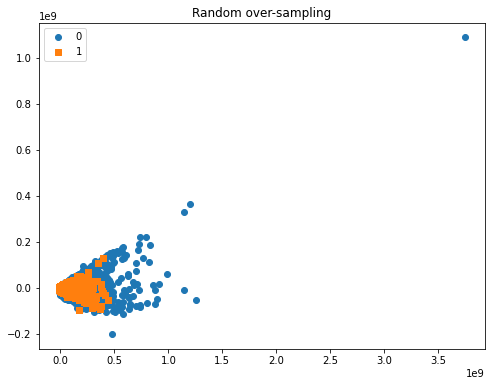

In [23]:
plot_2d_space(X_ros_pca, y_ros, 'Random over-sampling')

### Metrics

In [24]:
# Train and make predicions with model
model.fit(X_ros, y_ros)

preds_proba = model.predict_proba(test_features)[:, 1]
preds = model.predict(test_features)

ros_auc = roc_auc_score(test_labels, preds_proba)

print('The random oversampling model scores {:.5f} ROC AUC on the test set.'.format(
    ros_auc))

The random oversampling model scores 0.78027 ROC AUC on the test set.


In [25]:
cl_report_ros = classification_report(
    test_labels, preds, output_dict=True)

cus_metric_ros = custom_loss_function(test_labels, preds)
cus_metric_amt_ann_ros = custom_function_amt_credit(
    test_labels, preds, test_features)

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85     70622
           1       0.20      0.64      0.30      6256

    accuracy                           0.76     76878
   macro avg       0.58      0.71      0.58     76878
weighted avg       0.90      0.76      0.81     76878



## Tomek links

In [26]:
X_tl_imputed = imputer.fit_transform(train_features)

In [27]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X_tl_imputed, train_labels)

print('Features shape: ', X_tl.shape)
print('Labels shape: ', y_tl.shape)
print(y_tl.value_counts())

Features shape:  (223902, 278)
Labels shape:  (223902,)
0    205333
1     18569
Name: TARGET, dtype: int64


### Visualisation

In [28]:
X_tl_pca = pca.fit_transform(X_tl)

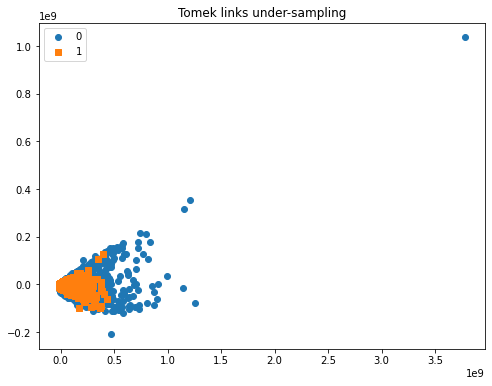

In [29]:
plot_2d_space(X_tl_pca, y_tl, 'Tomek links under-sampling')

### Metrics

In [30]:
# Train and make predicions with model
model.fit(X_tl, y_tl)

preds_proba = model.predict_proba(test_features)[:, 1]
preds = model.predict(test_features)

tl_auc = roc_auc_score(test_labels, preds_proba)

print('The Tomek links model scores {:.5f} ROC AUC on the test set.'.format(
    tl_auc))

The Tomek links model scores 0.72908 ROC AUC on the test set.


In [31]:
cl_report_tl = classification_report(
    test_labels, preds, output_dict=True)

cus_metric_tl = custom_loss_function(test_labels, preds)
cus_metric_amt_ann_tl = custom_function_amt_credit(
    test_labels, preds, test_features)

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     70622
           1       0.29      0.16      0.20      6256

    accuracy                           0.90     76878
   macro avg       0.61      0.56      0.57     76878
weighted avg       0.88      0.90      0.89     76878



## SMOTE

In [32]:
X_sm_imputed = imputer.fit_transform(train_features)

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_sm_imputed, train_labels)

print('Features shape: ', X_sm.shape)
print('Labels shape: ', y_sm.shape)
print(y_sm.value_counts())

Features shape:  (424128, 278)
Labels shape:  (424128,)
0    212064
1    212064
Name: TARGET, dtype: int64


### Visualisation

In [34]:
X_sm_pca = pca.fit_transform(X_sm)

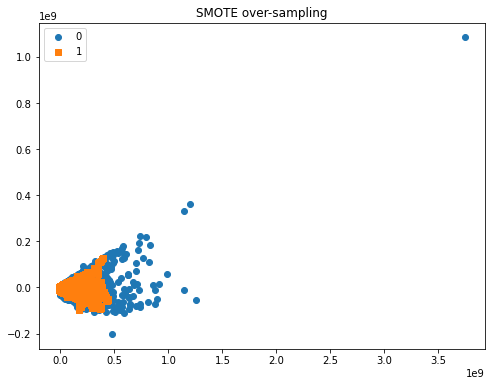

In [35]:
plot_2d_space(X_sm_pca, y_sm, 'SMOTE over-sampling')

### Metrics

In [36]:
# Train and make predicions with model
model.fit(X_sm, y_sm)

preds_proba = model.predict_proba(test_features)[:, 1]
preds = model.predict(test_features)

sm_auc = roc_auc_score(test_labels, preds_proba)

print('The SMOTE model scores {:.5f} ROC AUC on the test set.'.format(
    sm_auc))

The SMOTE model scores 0.73021 ROC AUC on the test set.


In [37]:
cl_report_sm = classification_report(
    test_labels, preds, output_dict=True)

cus_metric_sm = custom_loss_function(test_labels, preds)
cus_metric_amt_ann_sm = custom_function_amt_credit(
    test_labels, preds, test_features)

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     70622
           1       0.37      0.07      0.12      6256

    accuracy                           0.91     76878
   macro avg       0.65      0.53      0.54     76878
weighted avg       0.88      0.91      0.89     76878



# Metrics Table

In [38]:
dict_p = {'Imbalanced': [cl_report_imbalanced['0']['recall'], cl_report_imbalanced['1']['recall'], cl_report_imbalanced['0']['precision'], cl_report_imbalanced['1']['precision'], cl_report_imbalanced['accuracy'], imbalanced_auc],
          'Random Under Sampling': [cl_report_rus['0']['recall'], cl_report_rus['1']['recall'], cl_report_rus['0']['precision'], cl_report_rus['1']['precision'], cl_report_rus['accuracy'], rus_auc],
          'Random Over Sampling': [cl_report_ros['0']['recall'], cl_report_ros['1']['recall'], cl_report_ros['0']['precision'], cl_report_ros['1']['precision'], cl_report_ros['accuracy'], ros_auc],
          'Tomek Links': [cl_report_tl['0']['recall'], cl_report_tl['1']['recall'], cl_report_tl['0']['precision'], cl_report_tl['1']['precision'], cl_report_tl['accuracy'], tl_auc],
          'SMOTE': [cl_report_sm['0']['recall'], cl_report_sm['1']['recall'], cl_report_sm['0']['precision'], cl_report_sm['1']['precision'], cl_report_sm['accuracy'], sm_auc]
          }

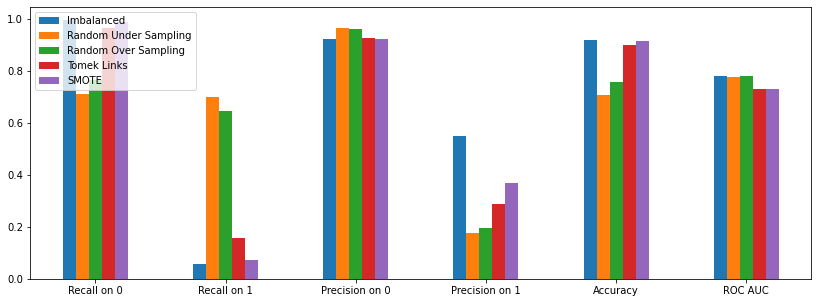

In [39]:
ax = pd.DataFrame(dict_p).plot(kind='bar', figsize=(14, 5))

ax.set_xticks(range(6))
ax.set_xticklabels(['Recall on 0', 'Recall on 1', 'Precision on 0',
                    'Precision on 1', 'Accuracy', 'ROC AUC'], rotation=0)

plt.show()

In [40]:
dict_p_custom = {'Imbalanced': [cus_metric_amt_ann_imbalanced, cus_metric_imbalanced/40000],
                 'Random Under Sampling': [cus_metric_amt_ann_rus, cus_metric_rus/40000],
                 'Random Over Sampling': [cus_metric_amt_ann_ros, cus_metric_ros/40000],
                 'Tomek Links': [cus_metric_amt_ann_tl, cus_metric_tl/40000],
                 'SMOTE': [cus_metric_amt_ann_sm, cus_metric_sm/40000],
                 }

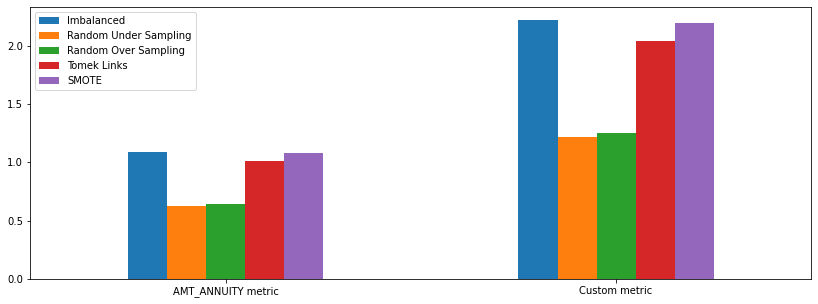

In [41]:
ax = pd.DataFrame(dict_p_custom).plot(kind='bar', figsize=(14, 5))

ax.set_xticks(range(2))
ax.set_xticklabels(['AMT_ANNUITY metric', 'Custom metric'], rotation=0)

plt.show()

# Final Model

In [42]:
model.fit(X_rus, y_rus)

LGBMClassifier(colsample_bytree=0.7422504150750135, force_col_wise=True,
               min_child_samples=266, n_estimators=168, num_leaves=43,
               random_state=17, reg_alpha=0.1, reg_lambda=0,
               subsample=0.5022832470118295, verbose=-1)

In [43]:
preds_proba = model.predict_proba(test_features)[:, 1]
preds = model.predict(test_features)

rus_auc = roc_auc_score(test_labels, preds_proba)

print('The random undersampling model scores {:.5f} ROC AUC on the test set.'.format(
    rus_auc))
print()
print(classification_report(test_labels, preds))

The random undersampling model scores 0.77735 ROC AUC on the test set.

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     70622
           1       0.18      0.70      0.28      6256

    accuracy                           0.71     76878
   macro avg       0.57      0.70      0.55     76878
weighted avg       0.90      0.71      0.77     76878



In [44]:
import pickle

with open('Final_Model.pkl', 'wb') as file:  
    pickle.dump(model, file)